In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchsummary import summary

from torchvision.utils import save_image
from IPython.core.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
from VAE.model import *
from VAE.data import *
from MDN_RNN.model import *

/tmp/ipykernel_4072/103143013.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import Image, display


device cuda is ready


In [3]:
z = np.load("Z.npy")
print(z.shape)
z = torch.from_numpy(z)

(71, 32, 32, 4, 4)


In [4]:
vae = VAE(32, batch_size=1).to(DEVICE)
vae.load_state_dict(torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/model.pt', weights_only=True))
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), 

In [5]:
z.size()

torch.Size([71, 32, 32, 4, 4])

In [6]:
z = z.view(16, -1, 512)
z.size()

torch.Size([16, 142, 512])

In [7]:
bsz = 16

In [8]:
zsize=512
nhidden=256
n_gaussians = 5

In [18]:
model = MDNRNN(zsize, nhidden).to(DEVICE)
model

MDNRNN(
  (lstm): LSTM(512, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=2560, bias=True)
  (fc2): Linear(in_features=256, out_features=2560, bias=True)
  (fc3): Linear(in_features=256, out_features=2560, bias=True)
)

In [19]:
seqlen=71

In [20]:
z.shape

torch.Size([16, 142, 512])

In [21]:
z.to(DEVICE)

tensor([[[-8.3291e-03, -6.6999e-03, -3.2741e-04,  ..., -2.8019e-03,
           2.1629e-03, -3.7699e-03],
         [-9.7147e-03, -6.6141e-03, -1.5208e-03,  ..., -2.7129e-03,
           9.0912e-03, -3.8212e-03],
         [-9.7472e-03, -7.5051e-03, -2.1227e-03,  ..., -2.4166e-03,
           7.8182e-03, -3.5227e-03],
         ...,
         [-8.5734e-03, -6.7054e-03,  9.2041e-03,  ..., -2.6160e-03,
           2.8146e-05, -4.0519e-03],
         [-9.1525e-03, -5.4989e-03, -1.5381e-05,  ..., -3.0179e-03,
           1.1161e-02, -3.9957e-03],
         [-9.2276e-03, -5.4786e-03,  3.5568e-04,  ..., -3.1216e-03,
           1.0393e-02, -3.8513e-03]],

        [[-9.6023e-03, -5.5357e-03, -3.2899e-04,  ..., -2.9603e-03,
           9.8240e-03, -3.7521e-03],
         [-9.9419e-03, -5.6339e-03, -9.4077e-04,  ..., -2.9889e-03,
           9.7526e-03, -3.7926e-03],
         [-1.0287e-02, -5.6745e-03, -1.4964e-03,  ..., -2.9870e-03,
           9.3895e-03, -3.8133e-03],
         ...,
         [-8.7030e-03, -5

In [22]:
train_RNN(epochs=500, seqlen=seqlen, model=model, z=z, bsz=bsz)

Epoch [0/500], Loss: 1.0585
Epoch [100/500], Loss: -1.6887
Epoch [200/500], Loss: -1.7434
Epoch [300/500], Loss: -2.1395
Epoch [400/500], Loss: -2.3137


In [23]:
zero = np.random.randint(z.size(0))
one = np.random.randint(z.size(1))
x = z[zero:zero+1, one:one+1, :].to(DEVICE)
y = z[zero:zero+1, one+1:one+2, :].to(DEVICE)

hidden = model.init_hidden(1)
(pi, mu, sigma), _ = model(x, hidden)

y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]

#compare_x = vae.decode()

# compare_x = vae.decode(z_out)
#save_image(compare_x.data.cpu(), 'sample_image.png')
#display(Image('sample_image.png', width=1000, unconfined=True))

In [24]:
ZZ = torch.cat([x, y] + y_preds)

In [25]:
ZZ.shape

torch.Size([7, 1, 512])

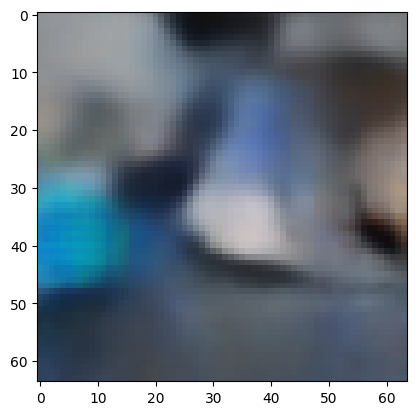

In [26]:
a = vae.decoder(ZZ[3][0].view(32, 4, 4).unsqueeze(0).to(DEVICE))
plt.imshow(a.detach().cpu().numpy().transpose(0, 2, 3, 1)[0])

In [27]:
z_next_pred[0][0][0][0].shape

NameError: name 'z_next_pred' is not defined

In [43]:
zero = np.random.randint(z.size(0))
one = np.random.randint(z.size(1))
x = z[zero:zero+1, one:one+1, :]
y = z[zero:zero+1, one+1:one+2, :]

hidden = model.init_hidden(1)
(pi, mu, sigma), _ = model(x.to(DEVICE), hidden)

y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]

In [49]:
ZZZ = torch.cat([x.to(DEVICE), y.to(DEVICE)] + y_preds)

In [66]:
a = []
for i in range(6):
    a.append(vae.decoder(ZZ[i][0].view(32, 4, 4).unsqueeze(0).to(DEVICE)))

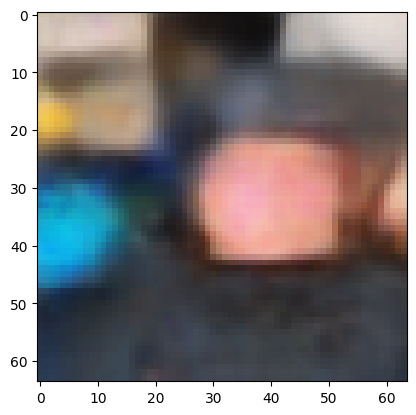

In [77]:
plt.imshow(a[0].detach().cpu().numpy().transpose(0, 2, 3, 1)[0])

Text(0.5, 1.0, 'real next')

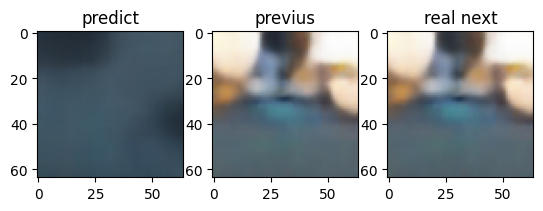

In [41]:
plt.subplot(1, 3, 1)
plt.imshow(a1[0])
plt.title("predict") 
plt.subplot(1, 3, 2)
plt.imshow(b1[0])
plt.title("previus") 
plt.subplot(1, 3, 3)
plt.imshow(c1[0])
plt.title("real next") 

# NEXT PREDICTION

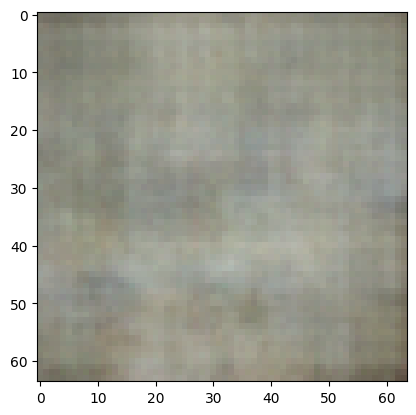

In [38]:
plt.imshow(a1[0])

# PREVIUS

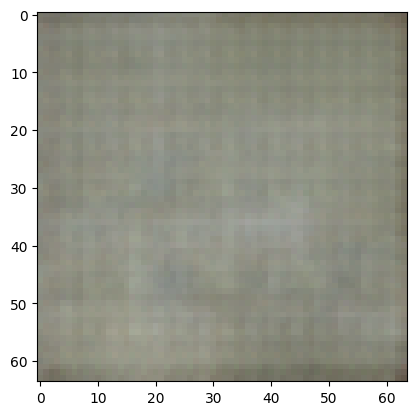

In [39]:
plt.imshow(b1[0])

# REAL NEXT CADR

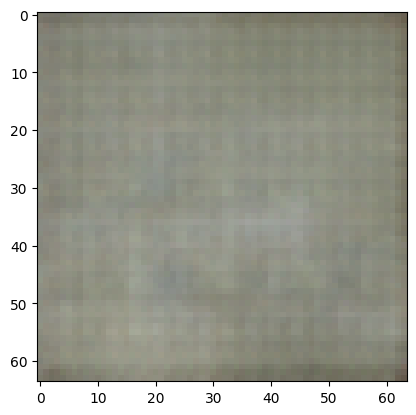

In [40]:
plt.imshow(c1[0])

In [41]:
torch.save(model, "RNN.pt")